# Image Captioning with RNNs

在本练习中，您将实现vanilla递归神经网络，并使用它们来训练能够为图像生成新颖描述的模型。

In [1]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from daseCV.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from daseCV.rnn_layers import *
from daseCV.captioning_solver import CaptioningSolver
from daseCV.classifiers.rnn import CaptioningRNN
from daseCV.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from daseCV.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
在本练习中，我们将使用2014年发布的[COCO数据集](https://cocodataset.org/)，一个标准的图像描述测试平台。这个数据集由80000个训练图像和40000个验证图像组成，每个图像都有5个由Amazon Mechanical Turk上的工作人员编写的描述注释。

**Image features.** 我们已经为您预处理了数据并提取了特征。对于所有的图像，我们都从预先在ImageNet上训练的VGG-16网络fc7层提取特征，并将这些特征存储在文件`train2014_vgg16_fc7.h5`和`val2014_vgg16_fc7.h5`中。为了减少处理时间和内存需求，我们使用主成分分析（PCA）将特征的维数从4096降到512，并将这些特征存储在文件 `train2014_vgg16_fc7_pca.h5` 和 `val2014_vgg16_fc7_pca.h5`中。原始图像占用了近20GB的空间，因此我们没有将其包含在下载中。由于所有图像都是从Flickr获取的，因此我们将训练和验证图像的url存储在文件`train2014_urls.txt` 和 `val2014_urls.txt`中。这允许您动态下载图像以进行可视化。

**Captions.** 处理字符串效率很低，因此我们将使用描述的编码版本。每个单词都分配了一个整数ID，允许我们用一系列整数来表示描述。整数id和单词之间的映射在文件`coco2014_vocab.json`中，您可以使用文件`daseCV/coco_utils.py`中的函数`decode_captions`将整数id的NumPy数组转换回字符串。

**Tokens.** 我们在词汇表中添加了几个特殊标记，我们已经为您处理了有关特殊标记的所有实现细节。我们在每个描述的开头和结尾分别添加一个特殊的`<START>`标记和一个`<END>`标记。罕见的单词将被一个特殊的`<UNK>`标记（表示“未知”）替换。此外，由于我们希望使用包含不同长度描述的小批量进行训练，因此我们在`<END>` 标记之后用一个特殊的`<NULL>` 标记填充短描述，并且不计算`<NULL>`标记的损失或梯度。

您可以使用文件`daseCV/coco_utils.py`中的`load_coco_data` 函数加载所有COCO数据（描述、特性、url和词汇表）。运行以下单元格以执行此操作：

In [2]:
# Load COCO data from disk into a dictionary.
# We'll work with dimensionality-reduced features for the remainder of this assignment,
# but you can also experiment with the original features on your own by changing the flag below.
BASE_DIR = "./input/datasets/coco_captioning"
data = load_coco_data(base_dir=BASE_DIR,pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  ./input/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Inspect the Data
在使用数据集之前，最好先查看数据集中的示例。

您可以使用文件`daseCV/coco_utils.py`中的`sample_coco_minibatch`函数从`load_coco_data`返回的数据结构中对小批量数据进行采样。运行下面的命令，对一小批训练数据进行采样，并显示图像及其描述。多次运行它并查看结果可以帮助您了解数据集。

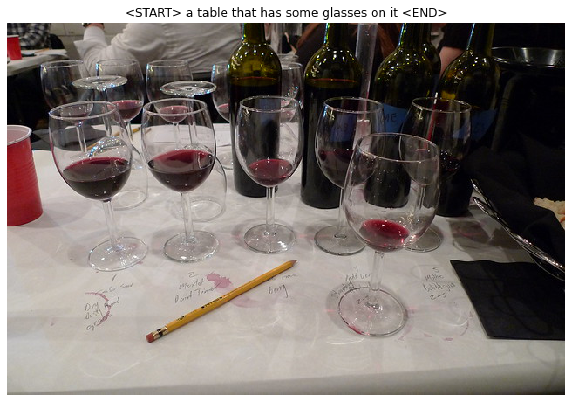

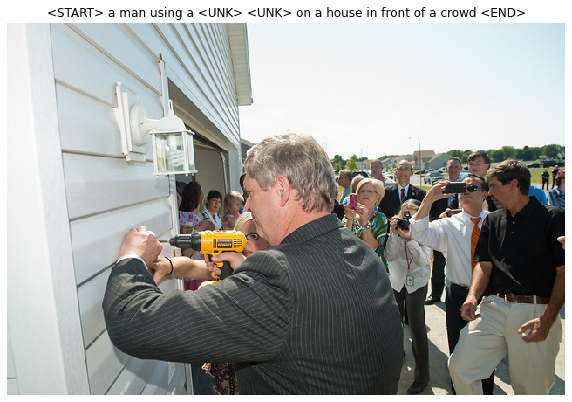

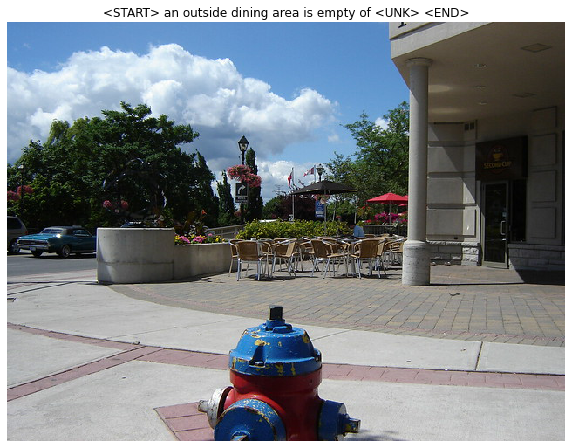

In [4]:
# Sample a minibatch and show the images and captions.
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Network
正如在讲座中所讨论的，我们将使用递归神经网络（RNN）语言模型进行图像描述。文件`daseCV/rnn_layers.py`包含递归神经网络所需的不同层类型的实现，而文件`daseCV/classifiers/rnn.py`使用这些层来实现图像描述模型。

我们将首先在`daseCV/rnn_layers.py`中实现不同类型的RNN层。

**NOTE:** 长-短期记忆（LSTM）RNN是普通RNN的一种常见变体。因为是可选的额外学分，所以现在不要担心在`daseCV/classifiers/rnn.py`和`daseCV/rnn_layers.py`中引用LSTM。

# Vanilla RNN: Step Forward

打开文件为`daseCV/rnn_layers.py`。该文件实现了递归神经网络中常用的不同类型层的向前和向后传递。

首先实现函数`rnn_step_forward`，它实现了一个普通递归神经网络的单时间步的前向传递。执行此操作后，运行以下命令检查实现。您应该可以看到`e-8`或更少数量级的错误。

In [7]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: Step Backward

在文件`daseCV/rnn_layers.py`中实现`rnn_step_backward`函数。执行此操作后，运行以下命令检查您的实现。你应该看到错误的顺序为`e-8`或更少

In [8]:
from daseCV.rnn_layers import rnn_step_forward, rnn_step_backward
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.0192769090159184e-10
dprev_h error:  2.5632975303201374e-10
dWx error:  8.820222259148609e-10
dWh error:  4.703287554560559e-10
db error:  7.30162216654e-11


# Vanilla RNN: Forward

现在您已经实现了普通RNN的单个时间步的向前和向后传递，您将组合这些部分来实现处理整个数据序列的RNN。

在文件`daseCV/rnn_layers.py`中，实现函数`rnn_forward`。这应该使用上面定义的`rnn_step_forward`函数来实现。执行此操作后，运行以下命令检查实现。您应该可以看到`e-7`或更少顺序的错误。

In [14]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466158305164e-08


# Vanilla RNN: Backward

在文件`daseCV/rnn_layers.py`中，对函数`rnn_backward`中的vanillar RNN实现向后传递。这应该在整个序列上运行反向传播，调用前面定义的`rnn_step_backward`函数。您应该看到e-6或更少的顺序上的错误。

In [15]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.5382468491701097e-09
dh0 error:  3.3839681556240896e-09
dWx error:  7.150535245339328e-09
dWh error:  1.297338408201546e-07
db error:  1.4889022954777414e-10


# Word Embedding: Forward

在深度学习系统中，我们通常使用向量来表示单词。词汇表中的每个单词都将与一个向量相关联，这些向量将与系统的其余部分一起学习。

在文件`daseCV/rnn_layers.py`中，实现函数`word_embedding_forward`将单词（由整数表示）转换为向量。运行以下命令检查您的实现。你应该看到一个错误的顺序`e-8`或更少。

In [18]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


# Word Embedding: Backward

在函数`word_embedding_backward`中实现单词嵌入函数的向后传递。执行此操作后，运行以下命令检查您的实现。你应该看到一个错误的顺序为`e-11`或更少。

In [19]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2774595693100364e-12


# Temporal Affine Layer

在每个时间步，我们使用仿射函数将该时间步的RNN隐藏向量转换为词汇表中每个单词的分数。因为这与您在赋值2中实现的仿射层非常相似，所以我们在`daseCV/rnn_layers.py`文件的`temporal_affine_forward`和`temporal_affine_backward`函数中为您提供了此函数。运行以下命令对实现执行数值渐变检查。您应该可以看到`e-9`或更少顺序的错误。

In [20]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  2.9215945034030545e-10
dw error:  1.5772088618663602e-10
db error:  3.252200556967514e-11


# Temporal Softmax Loss

在RNN语言模型中，我们在每个时间步为词汇表中的每个单词生成一个分数。我们知道每个时间步的真值，所以我们使用softmax损失函数来计算每个时间步的损失和梯度。我们计算了一段时间内的损失，并将其平均化。

但是有一个问题：由于我们对小批量进行操作，不同的描述可能有不同的长度，因此我们将`<NULL>` 标记附加到每个描述的末尾，使它们都具有相同的长度。我们不希望这些`<NULL>`标记计入损失或梯度，因此除了分数和地面真值标签之外，我们的损失函数还接受`mask`数组，告诉它分数的哪些元素计入损失。

由于这与您在作业1中实现的softmax损失函数非常相似，因此我们为您实现了此损失函数；查看文件`daseCV/rnn_layers.py`中的`temporal_softmax_loss`函数。

运行下面的单元格以检查丢失情况，并对函数执行数字渐变检查。您应该看到一个错误的dx的顺序为`e-7`或更少。

In [21]:
# Sanity check for temporal softmax loss
from daseCV.rnn_layers import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be within 2.2-2.4

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3027781774290146
23.025985953127226
2.2643611790293394
dx error:  2.583585303524283e-08


# RNN for Image Captioning
现在您已经实现了必要的层，您可以组合它们来构建图像描述模型。打开文件`daseCV/classifiers/rnn.py`，看看`CaptioningRNN`类。

在`loss`函数中实现模型的前后传递。现在你只需要实现`cell_type='rnn'` 代表vanialla RNNs的情况；稍后将实现LSTM案例。这样做之后，使用一个小测试用例运行以下命令来检查您的前向传递；你应该看到`e-10`或更小的错误。

In [23]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type='rnn',
    dtype=np.float64
)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.832355910027387
expected loss:  9.83235591003
difference:  2.6130209107577684e-12


运行下面的单元格对`CaptioningRNN`类执行数值渐变检查；您应该可以看到大约为`e-6`或更小的错误。

In [24]:
np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(
    word_to_idx,
    input_dim=input_dim,
    wordvec_dim=wordvec_dim,
    hidden_dim=hidden_dim,
    cell_type='rnn',
    dtype=np.float64,
)

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 2.331070e-09
W_proj relative error: 1.112417e-08
W_vocab relative error: 4.274379e-09
Wh relative error: 5.858117e-09
Wx relative error: 1.590657e-06
b relative error: 9.727211e-10
b_proj relative error: 1.934807e-08
b_vocab relative error: 7.087097e-11


# Overfit RNN Captioning Model on Small Data
类似于我们在上一个任务中用来训练图像分类模型的`Solver`类，在这个任务中我们使用`CaptioningSolver`类来训练图像描述模型。打开文件`daseCV/captioning_solver.py`，通读`CaptioningSolver`类；看上去应该很眼熟。

一旦您熟悉了API，请运行以下命令，以确保您的模型适合100个训练示例的小样本。最终损失应小于0.1。

base dir  ./input/datasets/coco_captioning
(Iteration 1 / 100) loss: 76.913487
(Iteration 11 / 100) loss: 21.063238
(Iteration 21 / 100) loss: 4.016202
(Iteration 31 / 100) loss: 0.567057
(Iteration 41 / 100) loss: 0.239462
(Iteration 51 / 100) loss: 0.162024
(Iteration 61 / 100) loss: 0.111550
(Iteration 71 / 100) loss: 0.097587
(Iteration 81 / 100) loss: 0.099104
(Iteration 91 / 100) loss: 0.073981


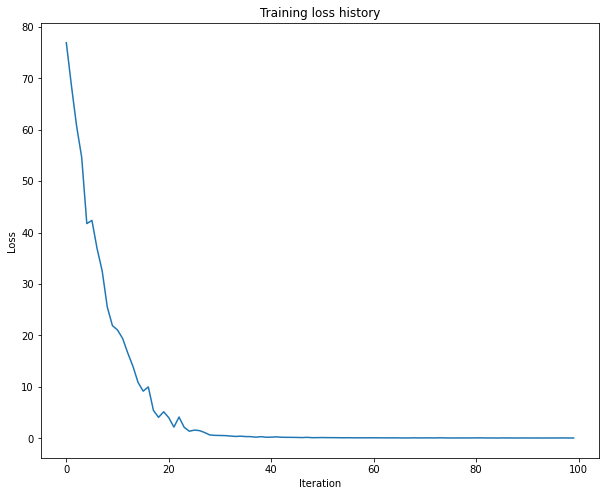

In [26]:
np.random.seed(231)

small_data = load_coco_data(base_dir=BASE_DIR, max_train=50)

small_rnn_model = CaptioningRNN(
    cell_type='rnn',
    word_to_idx=data['word_to_idx'],
    input_dim=data['train_features'].shape[1],
    hidden_dim=512,
    wordvec_dim=256,
)

small_rnn_solver = CaptioningSolver(
    small_rnn_model, small_data,
    update_rule='adam',
    num_epochs=50,
    batch_size=25,
    optim_config={
     'learning_rate': 5e-3,
    },
    lr_decay=0.95,
    verbose=True, print_every=10,
)

small_rnn_solver.train()

# Plot the training losses.
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.1.

In [27]:
print('Final loss: ', small_rnn_solver.loss_history[-1])

Final loss:  0.08209234134724225


# RNN Sampling at Test Time
与分类模型不同，图像描述模型在训练时和测试时的表现非常不同。由于在训练时，我们已知真实的描述，因此我们在每个时间步将真实的词汇输入到RNN。在测试时，我们在每个时间步从词汇表的分布中采样，并在下一个时间步将样本作为输入提供给RNN。

在文件`daseCV/classifiers/rnn.py`中，实现测试时间采样的`sample`方法。完成此操作后，运行以下命令从过度拟合的模型中对训练和验证数据进行采样。训练数据的样本应该很好。然而，验证数据上的样本可能没有意义。

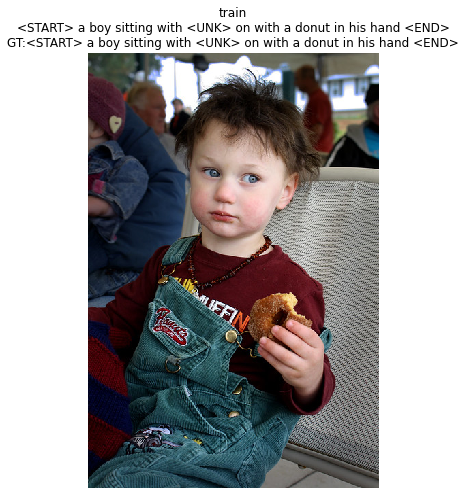

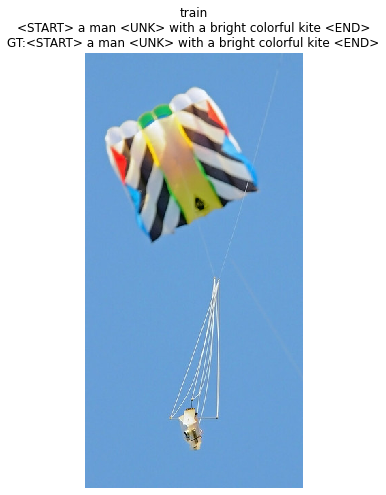

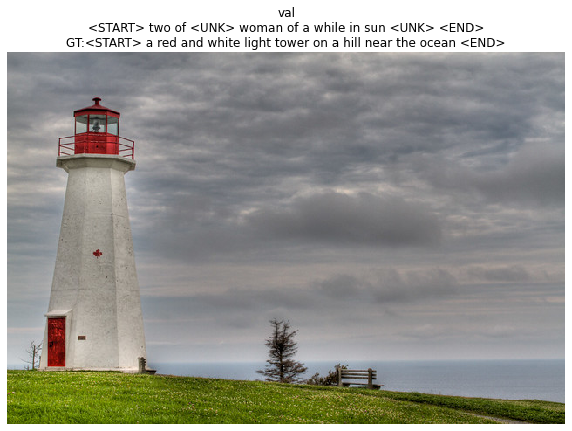

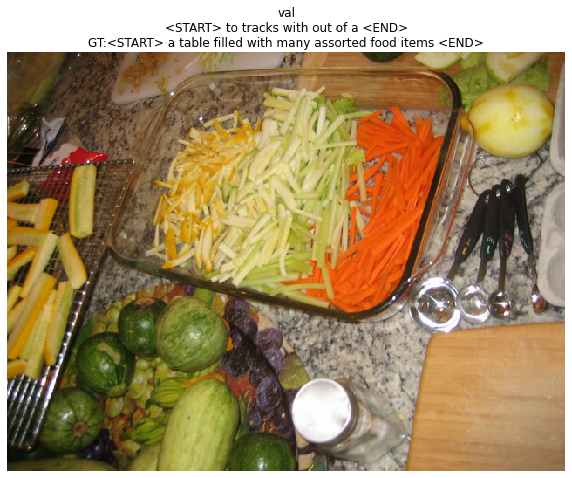

In [28]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)          
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Inline Question 1

在我们当前的图像描述设置中，我们的RNN语言模型在每个时间步产生一个单词作为它的输出。然而，提出问题的另一种方法是训练网络在字符（例如“a”、“b”等）上操作，而不是在单词上操作，这样在每一个时间步，它都会接收前一个字符作为输入，并尝试预测序列中的下一个字符。例如，网络可能会生成一个描述，如

'A', ' ', 'c', 'a', 't', ' ', 'o', 'n', ' ', 'a', ' ', 'b', 'e', 'd'

你能描述一下使用字符级RNN的图像描述模型的一个优点吗？你能描述一下一个缺点吗？提示：有几个有效的答案，但是比较单词级和字符级模型的参数空间可能会有用。

**Your Answer:** 
* 优点：参数空间小。字符级RNN的图像描述模型的单词列表只有26个字母，加上一些空格、标点等字符，这与单词级模型成千上万的单词比起来少了太多太多。这可以让网络的结构变得简单，使得网络运行地很快。
* 缺点：参数空间小在运行效率上是优点，但是容易让模型太过简单，仅仅改变几个字母，可能意思就改变了很多，这就是简单模型在复杂问题上的欠拟合问题，这成了它的缺点。同时，字母和字母的连接构成单词，这里涉及很复杂的、几乎没有规律可循的规则，相同的字母后面接上不同的字符组合，可以出现成千上万种意思，因此，训练出来的字符结果能否构成一个正确的单词也是一个问题。
